In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from data import load_data, SubsetWithAttributes, TRANSFORM
from utils import TRAINPATH, TESTPATH, save_pickle, load_pickle, LANDMARK_DICT, DATAPATH, LANDMARKS_ANGLES_DICT, PICKLEDPATH, BODY_POSE_CONNECTIONS, calc_angle
from plot import *
from pose import poses_for_dataset, estimate_poses, pose_landmarks_to_list
from classify import classify_image
import numpy as np
import mediapipe as mp
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision import transforms
plt.rcParams['figure.figsize'] = [12, 8]

mp_pose = mp.solutions.pose

### Read in Image

In [3]:
PATH = "/0_warrior2/Ashton-warrior-2-wrong.jpg"
EXAMPLE_PATH = str(TESTPATH)+PATH

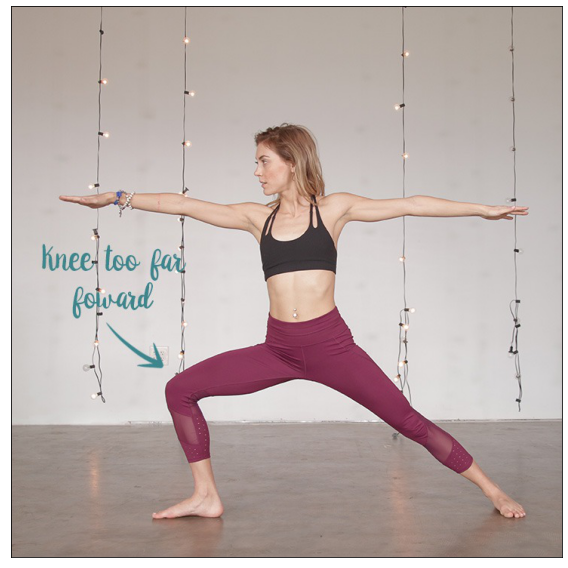

In [4]:
image = TRANSFORM(Image.open(EXAMPLE_PATH))
plot_image(image, dataloader=True)

### Apply Pose Estimation

In [5]:
result, annotated_image = estimate_poses(image, PATH)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


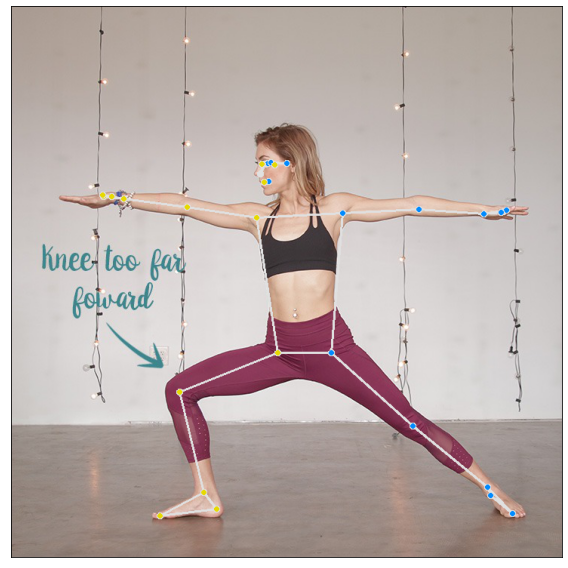

In [6]:
plot_image(annotated_image, dataloader=False)

In [7]:
val, _, nump = pose_landmarks_to_list(result, 'pose_world_landmarks')
df = pd.DataFrame.from_records([val])
numpy_data = np.array([nump])

### Pose Classification

In [8]:
classify_image(numpy_data)

KeyError: 'model_state_dict'